In [1]:
from torchvision.models.detection import fasterrcnn_resnet50_fpn, fasterrcnn_resnet50_fpn_v2
from torchvision.transforms import v2
from torchvision import tv_tensors
import numpy as np
import torch
from torchvision.io import read_image
from matplotlib import pyplot as plt
from torch.utils.data import Dataset, DataLoader
from tqdm import tqdm
import torch.optim as optim
import torch.nn as nn
import os
import pandas as pd

In [2]:
# List all of the important paths that we need and put them into usable variables for processing
base_dir = '/kaggle/input/byu-locating-bacterial-flagellar-motors-v2'
sample_csv_path = os.path.join(base_dir, 'sample_submission.csv')
train_csv_path = os.path.join(base_dir, 'train.csv')
train_path = os.path.join(base_dir, 'train')
test_path = os.path.join(base_dir, 'val')

# Check number of training and testing images
print(f'Number of training images: {len(os.listdir(train_path))}')
print(f'Number of testing images: {len(os.listdir(test_path))}')

Number of training images: 2770
Number of testing images: 1190


In [3]:
def train_test_split(test_ratio:float):
    """
    Create a training and testing split of the images.

    Parameters:
    test_ratio: float
        The ratio of the test set size to the total dataset size.
    """
    images = os.listdir(train_path)
    np.random.shuffle(images)
    split = int(len(images)*test_ratio)
    test_images = images[:split]
    train_images = images[split:]
    return train_images, test_images

In [4]:
#Check the train csv
train_df = pd.read_csv(train_csv_path)
train_df.head()

,image_name,x,y,motor_visible
0,0001.png,223,323,1
1,0002.png,-1,-1,0
2,0003.png,-1,-1,0
3,0004.png,-1,-1,0
4,0005.png,363,73,1


In [5]:
torch.cuda.is_available()

True

In [6]:
class TrainImageDataset(Dataset):
    def __init__(self, csv_file:str, images:list, train=True):
        super(TrainImageDataset, self).__init__()
        self.folder = '../input/byu-locating-bacterial-flagellar-motors-v2/train'
        self.images = images
        self.train = train
        self.csv_to_dict(csv_file)
        
        self.transform = v2.Compose([
                v2.RandomHorizontalFlip(p=0.5),
                v2.RandomVerticalFlip(p=0.5),
                v2.GaussianBlur(3, sigma=(0.1, 2.0)),
                v2.ColorJitter(brightness=[0.25,1.75]) 
            ])
        
    
    def csv_to_dict(self, csv_file):
        self.pos = {}
        with open(csv_file) as f:
            next(f)
            for line in f:
                filename, x, y, motor = line.strip().split(',')
                if int(motor):
                    self.pos[filename] = [int(x), int(y)]
                else:
                    self.pos[filename] = None
            

    def __getitem__(self, idx):
        file = self.images[idx]
        file_path = os.path.join(self.folder, file)
        img = read_image(file_path) / 255
        
        target = {}
        
        motor_coords = self.pos[file]
        
        if motor_coords:
            x, y = motor_coords
            box = torch.as_tensor([[x,y,x+1,y+1]], dtype=torch.float32)
            label = torch.as_tensor([1], dtype=torch.torch.int64)
        else:
            box = torch.as_tensor([[0,0,1,1]], dtype=torch.float32)
            label = torch.as_tensor([0], dtype=torch.torch.int64)
        if self.train:
            boxes = tv_tensors.BoundingBoxes(box, format="XYXY", canvas_size=(img.shape[1], img.shape[2]))
            imgs, bboxes = self.transform(img, boxes)
            if not motor_coords:
                bboxes = torch.tensor([[0,0,1,1]], dtype=torch.float32)
        return imgs, bboxes, label

    def __len__(self):
        return len(self.images)

In [7]:
model = fasterrcnn_resnet50_fpn_v2(num_classes=2, weights_backbone=True).cuda()

/opt/conda/lib/python3.10/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights_backbone' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights_backbone=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights_backbone=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/resnet50-0676ba61.pth" to /root/.cache/torch/hub/checkpoints/resnet50-0676ba61.pth
100%|██████████| 97.8M/97.8M [00:00<00:00, 151MB/s]


In [8]:
class ValImageDataset(Dataset):
    def __init__(self):
        super(ValImageDataset, self).__init__()
        self.folder = '../input/byu-locating-bacterial-flagellar-motors-v2/val'
        
        self.files = sorted(os.listdir(self.folder))
    

    def __getitem__(self, idx):
        file = self.files[idx]
        file_path = os.path.join(self.folder, file)
        img = read_image(file_path) / 255
    
        return file, img

    def __len__(self):
        return len(self.files)

In [9]:
# Create a train and test set from the training images
# train, test = train_test_split(0.1)
train = os.listdir(train_path)
print(len(train))

2770


In [10]:
assert torch.cuda.is_available() == True

In [11]:
batch_size = 10
lr = 0.00001
epochs = 10
test_interval = 25

losses = []
test_losses = []
test_accuracies = []
csv_path = '../input/byu-locating-bacterial-flagellar-motors-v2/train.csv'
optimizer = optim.Adam(model.parameters(), lr=lr)
train_dataset = TrainImageDataset(csv_path, train, train=True)
# test_dataset = TrainImageDataset(csv_path, test, train=False)
train_dataloader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
# test_dataloader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)


for epoch in range(epochs):
    model.train()
    progress_bar = tqdm(train_dataloader, total=len(train_dataloader))
    for batch,thing in enumerate(train_dataloader):
        images, boxes, labels = thing
        # add to cuda
        images = images.cuda()
        targets = []
        for i in range(batch_size):
            d = {}
            d['boxes'] = boxes[i].cuda()
            d['labels'] = labels[i].cuda()
            targets.append(d)
        
        optimizer.zero_grad()
        result = model(images, targets)
        
        
        loss = sum(loss for loss in result.values())
        losses.append(loss.item())

        loss.backward()
        optimizer.step()

        progress_bar.set_description(f"Epoch: {epoch} Batch: {batch} Train Loss:{loss} Test Loss: {test_losses[-1] if len(test_losses) > 0 else 0} Test Accuracy: {test_accuracies[-1] if len(test_accuracies) > 0 else 0}")
        progress_bar.update(1)
        
#         if batch % test_interval == 0:
#             # Assuming model is your trained model
#             model.eval()

#             # Define a loss function, for example, CrossEntropyLoss
#             criterion = nn.CrossEntropyLoss()

#             # Initialize variables to accumulate loss and accuracy
#             total_loss = 0.0
#             correct_predictions = 0
#             total_samples = 0

#             # Iterate through each batch in the validation dataset
#             for batch in test_dataloader:  # Assuming validation_loader is your DataLoader for the validation dataset
#                 images, boxes, labels = batch
#                 images = images.cuda()  # Assuming device is where your model is located
#                 labels = labels.cuda()

#                 # Forward pass
#                 with torch.no_grad():
#                     outputs = model(images)
#                     loss = criterion(outputs, labels)
#                     total_loss += loss.item() * images.size(0)

#                 # Calculate accuracy
#                 _, predicted = torch.max(outputs, 1)
#                 correct_predictions += (predicted == labels).sum().item()
#                 total_samples += labels.size(0)

#             # Calculate average loss and accuracy
#             average_loss = total_loss / total_samples
#             accuracy = correct_predictions / total_samples
#             test_losses.append(average_loss)
#             test_accuracy.append(accuracy)
                    
                    


    progress_bar.close()
print('TRAINING FINISHED')

Epoch: 0 Batch: 276 Train Loss:0.3375287353992462 Test Loss: 0 Test Accuracy: 0: 100%|██████████| 277/277 [12:33<00:00,  2.72s/it]
Epoch: 1 Batch: 276 Train Loss:0.15642745792865753 Test Loss: 0 Test Accuracy: 0: 100%|██████████| 277/277 [12:11<00:00,  2.64s/it]
Epoch: 2 Batch: 276 Train Loss:0.16124704480171204 Test Loss: 0 Test Accuracy: 0: 100%|██████████| 277/277 [12:11<00:00,  2.64s/it]
Epoch: 3 Batch: 276 Train Loss:0.11981306225061417 Test Loss: 0 Test Accuracy: 0: 100%|██████████| 277/277 [12:12<00:00,  2.65s/it]
Epoch: 4 Batch: 276 Train Loss:0.04008789733052254 Test Loss: 0 Test Accuracy: 0: 100%|██████████| 277/277 [12:13<00:00,  2.65s/it]
Epoch: 5 Batch: 276 Train Loss:0.10245736688375473 Test Loss: 0 Test Accuracy: 0: 100%|██████████| 277/277 [12:13<00:00,  2.65s/it]
Epoch: 6 Batch: 276 Train Loss:0.061454448848962784 Test Loss: 0 Test Accuracy: 0: 100%|██████████| 277/277 [12:14<00:00,  2.65s/it]
Epoch: 7 Batch: 276 Train Loss:0.06544695794582367 Test Loss: 0 Test Accurac

TRAINING FINISHED


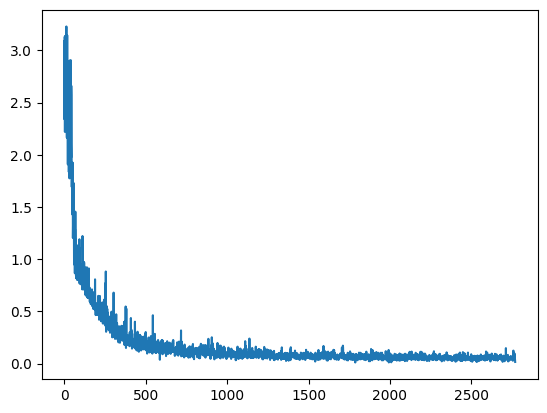

In [12]:
plt.plot(losses)
plt.show()

In [13]:
models_path = os.path.join(base_dir, 'models')
torch.save(model.state_dict(), 'rcnn_resnet50_v2_lr1e-5_epoch10.pt')


In [14]:
dataset = ValImageDataset()
dataloader = DataLoader(dataset, batch_size=1)

with open('submission.csv', 'w') as f:
    f.write('image_name,x,y,motor_visible\n')
    with torch.no_grad():
        model.eval()
        for thing in dataloader:
            filename, image = thing
            filename = filename[0]
            output = model(image.cuda())[0]
            
            boxes = output['boxes']
            
            row = [filename]
            
            if len(boxes) == 0:
                row.append('-1')
                row.append('-1')
                row.append('0')
            else:
                first_box = output['boxes'][0]
                x,y, _, _ = first_box
                row.append(str(x.item()))
                row.append(str(y.item()))
                row.append('1')
                
                
            line = ','.join(row) + '\n'
            f.write(line)